In [390]:
from AR_functions import AR_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [492]:
alternative_data_raw = pd.read_excel('/home/perann/Bureau/ENSAE/STAT_APP/EnsaeAlternativeTimeSeries.xlsx', sheet_name='Alternative Asset', index_col=0)


In [661]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index))
            .resample('QE')
            .last() #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)
            .drop(columns = ['Infrastructure_Equity_Listed_-_USD_Unhedged_%','Infrastructure_Equity_Listed_-_USD_Unhedged'])) # Replacing the spaces by _ in the names


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_return = alternative_data.iloc[:,8:]
alternative_return.tail()

/tmp/ipykernel_175744/4113115834.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .set_index(pd.to_datetime(df_.index))


,Commodity_-_USD_Unhedged_%,Global_Property_USD_Unhedged_%,Hedge_Fund_DJ_-_USD_Unhedged_%,Infrastructure_Debt_-_USD_Unhedged_%,Infrastructure_Equity_USD_Unhedged_%,Nature_Capital_-_USD_Hedged_%,Private_Equity_USD_Unhedged_%,UK_Property_Direct_-_USD_Unhedged_%
QUARTER,,,,,,,,
2022-09-30,-0.041072,-0.113868,0.003530,-0.063910,-0.138062,0.036852,-0.093622,-0.206764
2022-12-31,0.022188,0.071069,0.008177,0.023940,0.139286,0.031887,0.135844,0.118531
2023-03-31,-0.053612,0.010359,0.002603,0.031017,-0.031233,0.001511,0.069182,0.019827
2023-06-30,-0.025624,0.005429,0.017062,0.003213,-0.034827,NaN,0.084293,-0.014544
2023-09-30,0.039368,-0.014102,0.013006,0.003025,0.009360,NaN,0.017983,0.062951


In [662]:
def cumulated_returns(serie):
    return (1 + serie).cumprod() - 1

In [734]:
def data_unsmoothing(df_):
    new = df_.resample('ME').interpolate(method='polynomial', order = 2).pct_change()
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed= data_unsmoothing(alternative_data.iloc[:,0:8])
unsmoothed.head()

/tmp/ipykernel_175744/2235794183.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  new = df_.resample('ME').interpolate(method='polynomial', order = 2).pct_change()


,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_unsmoothed,Global_Property_USD_Unhedged_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_unsmoothed,Infrastructure_Equity_USD_Unhedged_unsmoothed,Nature_Capital_-_USD_Hedged_unsmoothed,Private_Equity_USD_Unhedged_unsmoothed,UK_Property_Direct_-_USD_Unhedged_unsmoothed
QUARTER,,,,,,,,,,,,,,,,
1993-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-31,NaN,NaN,NaN,NaN,NaN,NaN,0.044424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-02-28,NaN,NaN,NaN,NaN,NaN,NaN,0.030236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016049,NaN
1994-03-31,NaN,NaN,NaN,NaN,NaN,NaN,0.023701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017166,NaN
1994-04-30,NaN,NaN,NaN,NaN,NaN,NaN,0.013812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003923,NaN


In [735]:
to_interpolate = unsmoothed["Global_Property_USD_Unhedged_unsmoothed"]

In [736]:
quarter_return = alternative_return['Global_Property_USD_Unhedged_%'].dropna()

In [737]:
to_interpolate = unsmoothed["Global_Property_USD_Unhedged_unsmoothed"]
quarter_return = alternative_return['Global_Property_USD_Unhedged_%'].dropna()

def AR_rebase(serie,quarter):
    #serie = AR_model(serie.values)
    serie = serie.values
    for k in range(len(quarter)):
        serie[3*k+2] = ((1 + quarter[k])/((1 + serie[3*k+1])*(1 + serie[3*k]))) - 1
    return serie

quarter_return = quarter_return.iloc[1:]
to_interpolate = to_interpolate.dropna().iloc[2:]

interpolated = pd.Series(AR_rebase(to_interpolate,quarter_return), index = to_interpolate.index)


/tmp/ipykernel_175744/1870022240.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  serie[3*k+2] = ((1 + quarter[k])/((1 + serie[3*k+1])*(1 + serie[3*k]))) - 1


In [738]:
interpolated.values[:5]

array([-0.03966882, -0.05198424,  0.02823253,  0.03789249,  0.05115318])

In [739]:
(1+interpolated.values[0])*(1+interpolated.values[1])*(1+interpolated.values[2])-1

-0.06388775642109235

<Axes: xlabel='QUARTER'>

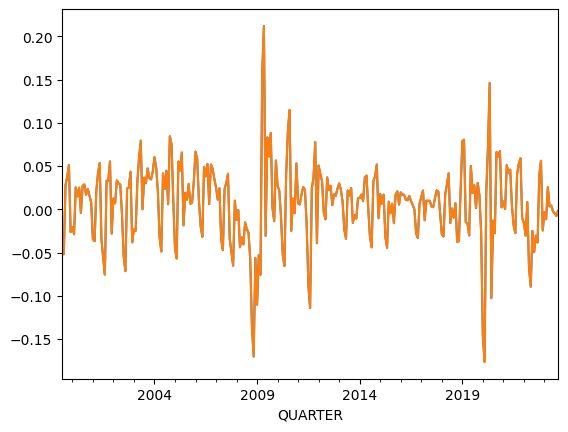

In [740]:
to_interpolate.plot()
interpolated.plot()

In [741]:
quarter_return

QUARTER
1999-09-30   -0.063888
1999-12-31    0.062225
2000-03-31   -0.024800
2000-06-30    0.036095
2000-09-30    0.074871
                ...   
2022-09-30   -0.113868
2022-12-31    0.071069
2023-03-31    0.010359
2023-06-30    0.005429
2023-09-30   -0.014102
Freq: QE-DEC, Name: Global_Property_USD_Unhedged_%, Length: 97, dtype: float64

In [742]:
to_interpolate.dropna()

QUARTER
1999-07-31   -0.039669
1999-08-31   -0.051984
1999-09-30    0.028233
1999-10-31    0.037892
1999-11-30    0.051153
                ...   
2023-05-31    0.004355
2023-06-30   -0.002414
2023-07-31   -0.004726
2023-08-31   -0.007639
2023-09-30   -0.001794
Freq: ME, Name: Global_Property_USD_Unhedged_unsmoothed, Length: 291, dtype: float64

In [743]:
interpolated.agg(cumulated_returns).loc[:"2004"].head(10)

QUARTER
1999-07-31   -0.039669
1999-08-31   -0.089591
1999-09-30   -0.063888
1999-10-31   -0.028416
1999-11-30    0.021283
1999-12-31   -0.005638
2000-01-31   -0.026177
2000-02-29   -0.054299
2000-03-31   -0.030298
2000-04-30   -0.015919
Freq: ME, dtype: float64

In [744]:
quarter_return.agg(cumulated_returns).loc[:"2004"]

QUARTER
1999-09-30   -0.063888
1999-12-31   -0.005638
2000-03-31   -0.030298
2000-06-30    0.004703
2000-09-30    0.079927
2000-12-31    0.131992
2001-03-31    0.074866
2001-06-30    0.139519
2001-09-30    0.027504
2001-12-31    0.088886
2002-03-31    0.147424
2002-06-30    0.209830
2002-09-30    0.087961
2002-12-31    0.119552
2003-03-31    0.100172
2003-06-30    0.259001
2003-09-30    0.408245
2003-12-31    0.575149
2004-03-31    0.787634
2004-06-30    0.713852
2004-09-30    0.843666
2004-12-31    1.173128
Freq: QE-DEC, Name: Global_Property_USD_Unhedged_%, dtype: float64

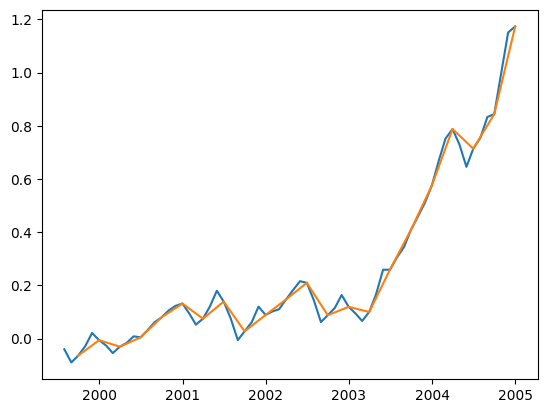

In [745]:
plt.plot(interpolated.agg(cumulated_returns).loc[:"2004"].index, interpolated.agg(cumulated_returns).loc[:"2004"])
plt.plot(quarter_return.agg(cumulated_returns).loc[:"2004"].index, quarter_return.agg(cumulated_returns).loc[:"2004"])
plt.show()

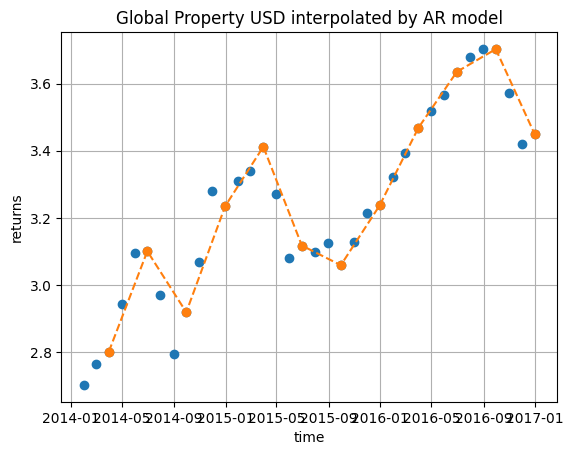

In [746]:
plt.figure()
plt.plot(interpolated.agg(cumulated_returns).loc["2014":"2016"].index, interpolated.agg(cumulated_returns).loc["2014":"2016"],'o')
plt.plot(quarter_return.agg(cumulated_returns).loc["2014":"2016"].index, quarter_return.agg(cumulated_returns).loc["2014":"2016"],'o--')
plt.xlabel("time")
plt.ylabel('returns')
plt.title("Global Property USD interpolated by AR model")
plt.grid()

 # AR REBASE 2: Pipe

In [781]:
alternative_data_raw = pd.read_excel('/home/perann/Bureau/ENSAE/STAT_APP/EnsaeAlternativeTimeSeries.xlsx', sheet_name='Alternative Asset', index_col=0)

In [784]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index))
            .resample('QE')
            .last() #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)
            .drop(columns = ['Infrastructure_Equity_Listed_-_USD_Unhedged_%','Infrastructure_Equity_Listed_-_USD_Unhedged'])) # Replacing the spaces by _ in the names


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_return = alternative_data.iloc[:,8:]

/tmp/ipykernel_175744/1179806071.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .set_index(pd.to_datetime(df_.index))


In [785]:
def data_unsmoothing(df_):
    new = df_.resample('ME').interpolate(method='polynomial', order = 2).pct_change()
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed= data_unsmoothing(alternative_data.iloc[:,0:8])
unsmoothed.head()

/tmp/ipykernel_175744/2235794183.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  new = df_.resample('ME').interpolate(method='polynomial', order = 2).pct_change()


,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_unsmoothed,Global_Property_USD_Unhedged_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_unsmoothed,Infrastructure_Equity_USD_Unhedged_unsmoothed,Nature_Capital_-_USD_Hedged_unsmoothed,Private_Equity_USD_Unhedged_unsmoothed,UK_Property_Direct_-_USD_Unhedged_unsmoothed
QUARTER,,,,,,,,,,,,,,,,
1993-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-31,NaN,NaN,NaN,NaN,NaN,NaN,0.044424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-02-28,NaN,NaN,NaN,NaN,NaN,NaN,0.030236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016049,NaN
1994-03-31,NaN,NaN,NaN,NaN,NaN,NaN,0.023701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017166,NaN
1994-04-30,NaN,NaN,NaN,NaN,NaN,NaN,0.013812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003923,NaN


In [854]:
def oui(name):
    to_interpolate = unsmoothed[ name +"_unsmoothed"]
    quarter_return = alternative_return[ name + '_%'].dropna()

    def AR_rebase(serie,quarter):
        #serie = AR_model(serie.values)
        serie = serie.values
        for k in range(len(quarter)):
            serie[3*k+2] = ((1 + quarter[k])/((1 + serie[3*k+1])*(1 + serie[3*k]))) - 1
        return serie

    quarter_return = quarter_return.loc['2008-03-31':]
    to_interpolate = to_interpolate.dropna().loc['2008-01-31':]

    interpolated = pd.Series(AR_rebase(to_interpolate,quarter_return), index = to_interpolate.index)
    return interpolated, quarter_return

In [832]:
alternative_data.columns

Index(['Commodity_-_USD_Unhedged', 'Global_Property_USD_Unhedged',
       'Hedge_Fund_DJ_-_USD_Unhedged', 'Infrastructure_Debt_-_USD_Unhedged',
       'Infrastructure_Equity_USD_Unhedged', 'Nature_Capital_-_USD_Hedged',
       'Private_Equity_USD_Unhedged', 'UK_Property_Direct_-_USD_Unhedged',
       'Commodity_-_USD_Unhedged_%', 'Global_Property_USD_Unhedged_%',
       'Hedge_Fund_DJ_-_USD_Unhedged_%',
       'Infrastructure_Debt_-_USD_Unhedged_%',
       'Infrastructure_Equity_USD_Unhedged_%', 'Nature_Capital_-_USD_Hedged_%',
       'Private_Equity_USD_Unhedged_%', 'UK_Property_Direct_-_USD_Unhedged_%'],
      dtype='object')

In [863]:
interpolated, quarter_return = oui('Infrastructure_Equity_USD_Unhedged')

/tmp/ipykernel_175744/2064823133.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  serie[3*k+2] = ((1 + quarter[k])/((1 + serie[3*k+1])*(1 + serie[3*k]))) - 1


In [864]:
interpolated.agg(cumulated_returns).head(20)

QUARTER
2008-01-31   -0.000382
2008-02-29   -0.003168
2008-03-31    0.028364
2008-04-30    0.075769
2008-05-31    0.127272
2008-06-30    0.106802
2008-07-31    0.020831
2008-08-31   -0.097492
2008-09-30   -0.103943
2008-10-31   -0.216913
2008-11-30   -0.315597
2008-12-31   -0.357501
2009-01-31   -0.347586
2009-02-28   -0.301134
2009-03-31   -0.336475
2009-04-30   -0.264934
2009-05-31   -0.179327
2009-06-30   -0.163077
2009-07-31   -0.167688
2009-08-31   -0.188677
Freq: ME, dtype: float64

In [865]:
quarter_return.agg(cumulated_returns)

QUARTER
2008-03-31    0.028364
2008-06-30    0.106802
2008-09-30   -0.103943
2008-12-31   -0.357501
2009-03-31   -0.336475
                ...   
2022-09-30    1.066925
2022-12-31    1.354818
2023-03-31    1.281270
2023-06-30    1.201819
2023-09-30    1.222429
Freq: QE-DEC, Name: Infrastructure_Equity_USD_Unhedged_%, Length: 63, dtype: float64

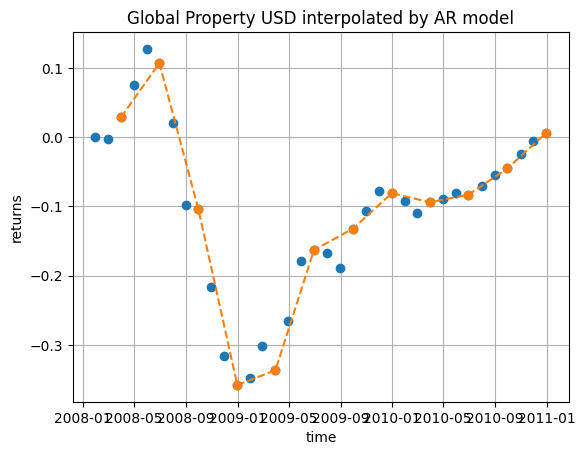

In [866]:
plt.figure()
plt.plot(interpolated.agg(cumulated_returns).loc[:"2010"].index, interpolated.agg(cumulated_returns).loc[:"2010"],'o')
plt.plot(quarter_return.agg(cumulated_returns).loc[:"2010"].index, quarter_return.agg(cumulated_returns).loc[:"2010"],'o--')
plt.xlabel("time")
plt.ylabel('returns')
plt.title("Global Property USD interpolated by AR model")
plt.grid()

In [870]:
alternative_data.columns[:8]

Index(['Commodity_-_USD_Unhedged', 'Global_Property_USD_Unhedged',
       'Hedge_Fund_DJ_-_USD_Unhedged', 'Infrastructure_Debt_-_USD_Unhedged',
       'Infrastructure_Equity_USD_Unhedged', 'Nature_Capital_-_USD_Hedged',
       'Private_Equity_USD_Unhedged', 'UK_Property_Direct_-_USD_Unhedged'],
      dtype='object')

# AR rebasé : Pipeline

In [747]:
alternative_data_raw = pd.read_excel('/home/perann/Bureau/ENSAE/STAT_APP/EnsaeAlternativeTimeSeries.xlsx', sheet_name='Alternative Asset', index_col=0)

In [748]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index))
            .resample('QE')
            .last() #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)
            .drop(columns = ['Infrastructure_Equity_Listed_-_USD_Unhedged_%','Infrastructure_Equity_Listed_-_USD_Unhedged'])) # Replacing the spaces by _ in the names


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_return = alternative_data.iloc[:,8:]

/tmp/ipykernel_175744/1179806071.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .set_index(pd.to_datetime(df_.index))


In [750]:
def data_unsmoothing(df_):
    new = df_.resample('ME').interpolate(method='polynomial', order = 2).pct_change()
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed = data_unsmoothing(alternative_data.iloc[:,0:8])

/tmp/ipykernel_175744/4255242419.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  new = df_.resample('ME').interpolate(method='polynomial', order = 2).pct_change()


In [751]:
def AR_final(name):
    to_interpolate = unsmoothed[name + "_unsmoothed"]
    quarter_return = alternative_return[name + '_%'].dropna()

    def AR_rebase(serie,quarter):
        serie = serie.values
        for k in range(len(quarter)):
            serie[3*k+2] = ((1 + quarter[k])/((1 + serie[3*k+1])*(1 + serie[3*k]))) - 1
        return serie

    quarter_return = quarter_return.loc["2007-09-30":]#.iloc[1:]
    to_interpolate = to_interpolate.dropna().loc["2007-07-31":]#.iloc[2:]

    interpolated = pd.Series(AR_rebase(to_interpolate,quarter_return), index = to_interpolate.index)
    return interpolated

In [719]:
def AR_final(name):

    to_interpolate = unsmoothed[name + "_unsmoothed"]
    quarter_return = alternative_return[name+'_%'].dropna()

    def AR_rebase(serie,quarter):
        #serie = AR_model(serie.values)
        serie = serie.values
        for k in range(len(quarter)):
            serie[3*k+2] = ((1 + quarter[k])/((1 + serie[3*k+1])*(1 + serie[3*k]))) - 1
        return serie

    quarter_return = quarter_return.loc["2010-06-30":]
    to_interpolate = to_interpolate.dropna().loc["2010-03-31":]

    interpolated = pd.Series(AR_rebase(to_interpolate,quarter_return), index = to_interpolate.index)
    return interpolated

In [752]:
interpolated = AR_final('Global_Property_USD_Unhedged')

/tmp/ipykernel_175744/3256782420.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  serie[3*k+2] = ((1 + quarter[k])/((1 + serie[3*k+1])*(1 + serie[3*k]))) - 1


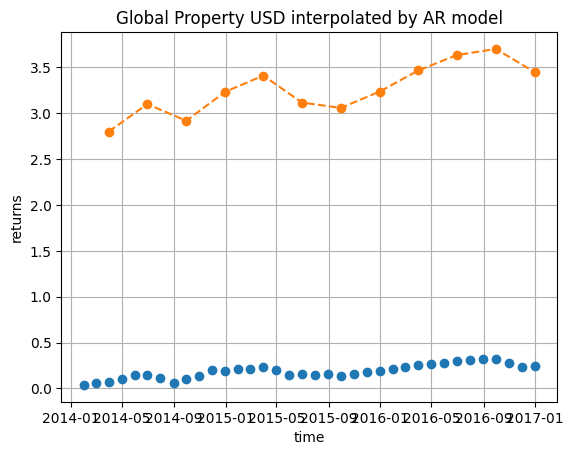

In [753]:
plt.figure()
plt.plot(interpolated.agg(cumulated_returns).loc["2014":"2016"].index, interpolated.agg(cumulated_returns).loc["2014":"2016"],'o')
plt.plot(quarter_return.agg(cumulated_returns).loc["2014":"2016"].index, quarter_return.agg(cumulated_returns).loc["2014":"2016"],'o--')
plt.xlabel("time")
plt.ylabel('returns')
plt.title("Global Property USD interpolated by AR model")
plt.grid()

In [591]:
serie_commo = AR_final('Commodity_-_USD_Unhedged')
serie_GP =  AR_final('Global_Property_USD_Unhedged')
serie_hedge = AR_final('Hedge_Fund_DJ_-_USD_Unhedged')
serie_uk_prop = AR_final('UK_Property_Direct_-_USD_Unhedged')
serie_infra_debt = AR_final('Infrastructure_Debt_-_USD_Unhedged')
serie_nat_cap = AR_final('Nature_Capital_-_USD_Hedged')
serie_pe = AR_final('Private_Equity_USD_Unhedged')
#serie_infra_equ = AR_final('Infrastructure_Equity_USD_Unhedged')	

/tmp/ipykernel_175744/1254401707.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  serie[3*k+2] = ((1 + quarter[k])/((1 + serie[3*k+1])*(1 + serie[3*k]))) - 1


In [699]:
serie_commo

QUARTER
2007-04-30   -0.008087
2007-05-31   -0.011314
2007-06-30    0.018377
2007-07-31    0.027269
2007-08-31    0.034096
                ...   
2023-05-31   -0.003554
2023-06-30   -0.013597
2023-07-31    0.013201
2023-08-31    0.020934
2023-09-30    0.004791
Freq: ME, Length: 198, dtype: float64

In [592]:
serie_infra_equ = AR_final('Infrastructure_Equity_USD_Unhedged')

/tmp/ipykernel_175744/1254401707.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  serie[3*k+2] = ((1 + quarter[k])/((1 + serie[3*k+1])*(1 + serie[3*k]))) - 1


IndexError: index 197 is out of bounds for axis 0 with size 197

# Modèles naifs : Linéaire

In [604]:
price = alternative_data.loc['31-03-2007':].iloc[:,:8]

In [608]:
linear_returns = price.resample('ME').interpolate(method = 'linear').pct_change()
linear_returns.head()

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged
QUARTER,,,,,,,,
2007-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-30,-0.000429,-0.019504,0.017299,-0.003971,0.022482,0.012454,0.011437,-0.023148
2007-05-31,-0.000429,-0.019892,0.017005,-0.003987,0.021988,0.012300,0.011307,-0.023696
2007-06-30,-0.000430,-0.020296,0.016721,-0.004003,0.021515,0.012151,0.011181,-0.024271
2007-07-31,0.020809,0.012186,0.003763,0.010769,-0.008341,0.005997,-0.015508,-0.014237


Text(0.5, 1.0, 'Linear Interpolation')

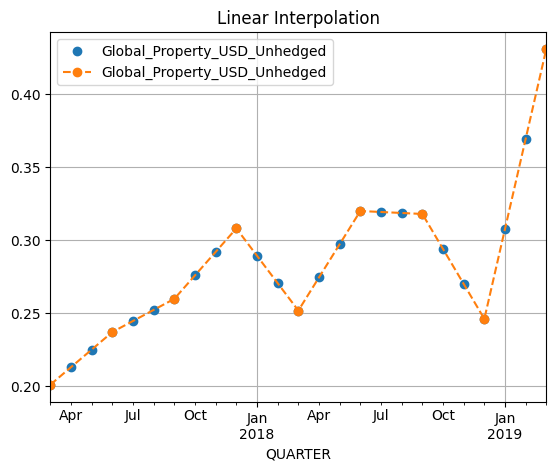

In [609]:
fig, axis = plt.subplots()

(linear_returns.Global_Property_USD_Unhedged
 .agg(cumulated_returns)
 .loc['31-03-2017' : '31-03-2019']
.plot(ax = axis, style = 'o',grid = True)
.legend())


(price.Global_Property_USD_Unhedged
 .resample('ME')
 .interpolate('linear')
 .pct_change()
 .agg(cumulated_returns)
 .loc['31-03-2017': '31-03-2019']
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True)
 .legend())

axis.set_title('Linear Interpolation')

## Correlation matrix

In [445]:
(linear_returns.loc['2017-12-31':'2022-12-31'].corr()
.style.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None))

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged
Commodity_-_USD_Unhedged,1.00,0.66,0.81,-0.22,0.43,0.77,0.59,0.61
Global_Property_USD_Unhedged,0.66,1.00,0.83,0.32,0.80,0.53,0.92,0.88
Hedge_Fund_DJ_-_USD_Unhedged,0.81,0.83,1.00,0.01,0.62,0.62,0.88,0.73
Infrastructure_Debt_-_USD_Unhedged,-0.22,0.32,0.01,1.00,0.43,-0.43,0.33,0.35
Infrastructure_Equity_USD_Unhedged,0.43,0.80,0.62,0.43,1.00,0.27,0.77,0.86
Nature_Capital_-_USD_Hedged,0.77,0.53,0.62,-0.43,0.27,1.00,0.45,0.38
Private_Equity_USD_Unhedged,0.59,0.92,0.88,0.33,0.77,0.45,1.00,0.84
UK_Property_Direct_-_USD_Unhedged,0.61,0.88,0.73,0.35,0.86,0.38,0.84,1.00


## Volatility

In [446]:
def volatility_from_month(x):
    return np.sqrt(12)*x.std()

In [447]:
linear_returns.loc['2017-12-31':'2022-12-31'].agg(volatility_from_month)

Commodity_-_USD_Unhedged              0.110196
Global_Property_USD_Unhedged          0.124947
Hedge_Fund_DJ_-_USD_Unhedged          0.038985
Infrastructure_Debt_-_USD_Unhedged    0.034297
Infrastructure_Equity_USD_Unhedged    0.096100
Nature_Capital_-_USD_Hedged           0.081746
Private_Equity_USD_Unhedged           0.179881
UK_Property_Direct_-_USD_Unhedged     0.132688
dtype: float64

#  **Modèle Naïfs : modèle quadratique**

In [448]:
price = alternative_data.loc['31-03-2007':].iloc[:,:8]
quadratic_return = price.resample('ME').interpolate(method = 'quadratic').pct_change()

/tmp/ipykernel_175744/1888440700.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  quadratic_return = price.resample('ME').interpolate(method = 'quadratic').pct_change()


Text(0.5, 1.0, 'Quadratic Interpolation')

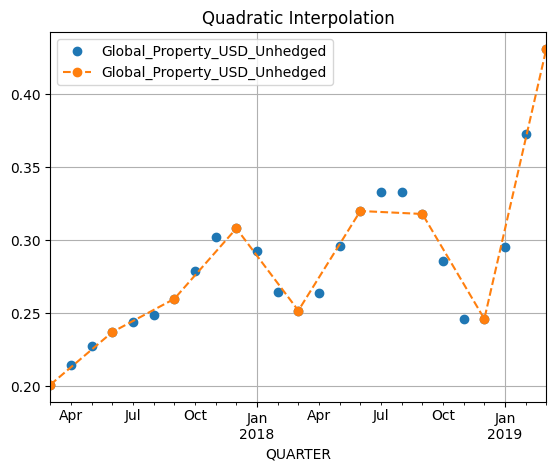

In [467]:
fig, axis = plt.subplots()

(quadratic_return.Global_Property_USD_Unhedged
 .agg(cumulated_returns)
 .loc['31-03-2017' : '31-03-2019']
.plot(ax = axis, style = 'o',grid = True)
.legend())


(price.Global_Property_USD_Unhedged
 .resample('ME')
 .interpolate('linear')
 .pct_change()
 .agg(cumulated_returns)
 .loc['31-03-2017': '31-03-2019']
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True)
 .legend())

axis.set_title('Quadratic Interpolation')

## Correlation

In [450]:
(quadratic_return.loc['2017-12-31':'2022-12-31'].corr()
.style.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None))

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged
Commodity_-_USD_Unhedged,1.00,0.66,0.81,-0.21,0.44,0.77,0.60,0.62
Global_Property_USD_Unhedged,0.66,1.00,0.84,0.30,0.81,0.55,0.92,0.88
Hedge_Fund_DJ_-_USD_Unhedged,0.81,0.84,1.00,-0.00,0.63,0.64,0.88,0.74
Infrastructure_Debt_-_USD_Unhedged,-0.21,0.30,-0.00,1.00,0.41,-0.42,0.31,0.33
Infrastructure_Equity_USD_Unhedged,0.44,0.81,0.63,0.41,1.00,0.30,0.78,0.86
Nature_Capital_-_USD_Hedged,0.77,0.55,0.64,-0.42,0.30,1.00,0.47,0.40
Private_Equity_USD_Unhedged,0.60,0.92,0.88,0.31,0.78,0.47,1.00,0.84
UK_Property_Direct_-_USD_Unhedged,0.62,0.88,0.74,0.33,0.86,0.40,0.84,1.00


## Volatility

In [451]:
quadratic_return.loc['2017-12-31':'2022-12-31'].agg(volatility_from_month)

Commodity_-_USD_Unhedged              0.117735
Global_Property_USD_Unhedged          0.132941
Hedge_Fund_DJ_-_USD_Unhedged          0.041696
Infrastructure_Debt_-_USD_Unhedged    0.035679
Infrastructure_Equity_USD_Unhedged    0.103090
Nature_Capital_-_USD_Hedged           0.085163
Private_Equity_USD_Unhedged           0.191424
UK_Property_Direct_-_USD_Unhedged     0.141710
dtype: float64